In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchcp.classification.scores import THR, APS, RAPS, SAPS, Margin
from torchcp.utils import fix_randomness
from torchcp.classification.utils.metrics import Metrics

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Simple CNN model for demonstration purposes
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = torch.nn.Linear(14 * 14 * 32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 14 * 14 * 32)
        x = self.fc(x)
        return x

def test_fmnist():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fix_randomness(seed=0)
    model_name = 'CNN'
    
    fmnist_test = FashionMNIST(root='./shareddata', train=False, download=True, transform=transform)

    dataset_length = len(fmnist_test)

    cal_length = int(0.6 * dataset_length)
    test_length = dataset_length - cal_length 

    cal_dataset, test_dataset = torch.utils.data.random_split(fmnist_test, [cal_length, test_length])

    model = SimpleCNN()
    model.to(device)

    cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64, shuffle=True, pin_memory=True)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
    
    alpha_values = [0.1, 0.2, 0.5]  # 举例，可以根据需要扩展
    predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
    score_functions = [THR(), APS(), RAPS(1, 0), SAPS(0.2), Margin()]

    for alpha in alpha_values:
        for score in score_functions:
            for class_predictor in predictors:
                predictor = class_predictor(score, model)
                predictor.calibrate(cal_data_loader, alpha)

                # Print experiment details and save results to a file
                experiment_details = f"Experiment--Data : FashionMNIST, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}"
                print(experiment_details)
            
                evaluation_results = predictor.evaluate(test_data_loader)
                print(evaluation_results)

                with open('experiment_results.txt', 'a') as file:
                    file.write(experiment_details + '\n')
                    file.write(str(evaluation_results) + '\n')

In [18]:
test_fmnist()

Experiment--Data : FashionMNIST, Model : CNN, Score : THR, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.90175, 'Average_size': 9.35475}
Experiment--Data : FashionMNIST, Model : CNN, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.89925, 'Average_size': 8.41775}
Experiment--Data : FashionMNIST, Model : CNN, Score : THR, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.90175, 'Average_size': 9.3545}
Experiment--Data : FashionMNIST, Model : CNN, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.90175, 'Average_size': 9.20275}
Experiment--Data : FashionMNIST, Model : CNN, Score : APS, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.89775, 'Average_size': 8.25475}
Experiment--Data : FashionMNIST, Model : CNN, Score : APS, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.905, 'Average_size': 9.22375}
Experiment--Data : FashionMNIST, Model : CNN, Score : RAPS, Predictor : SplitPredicto

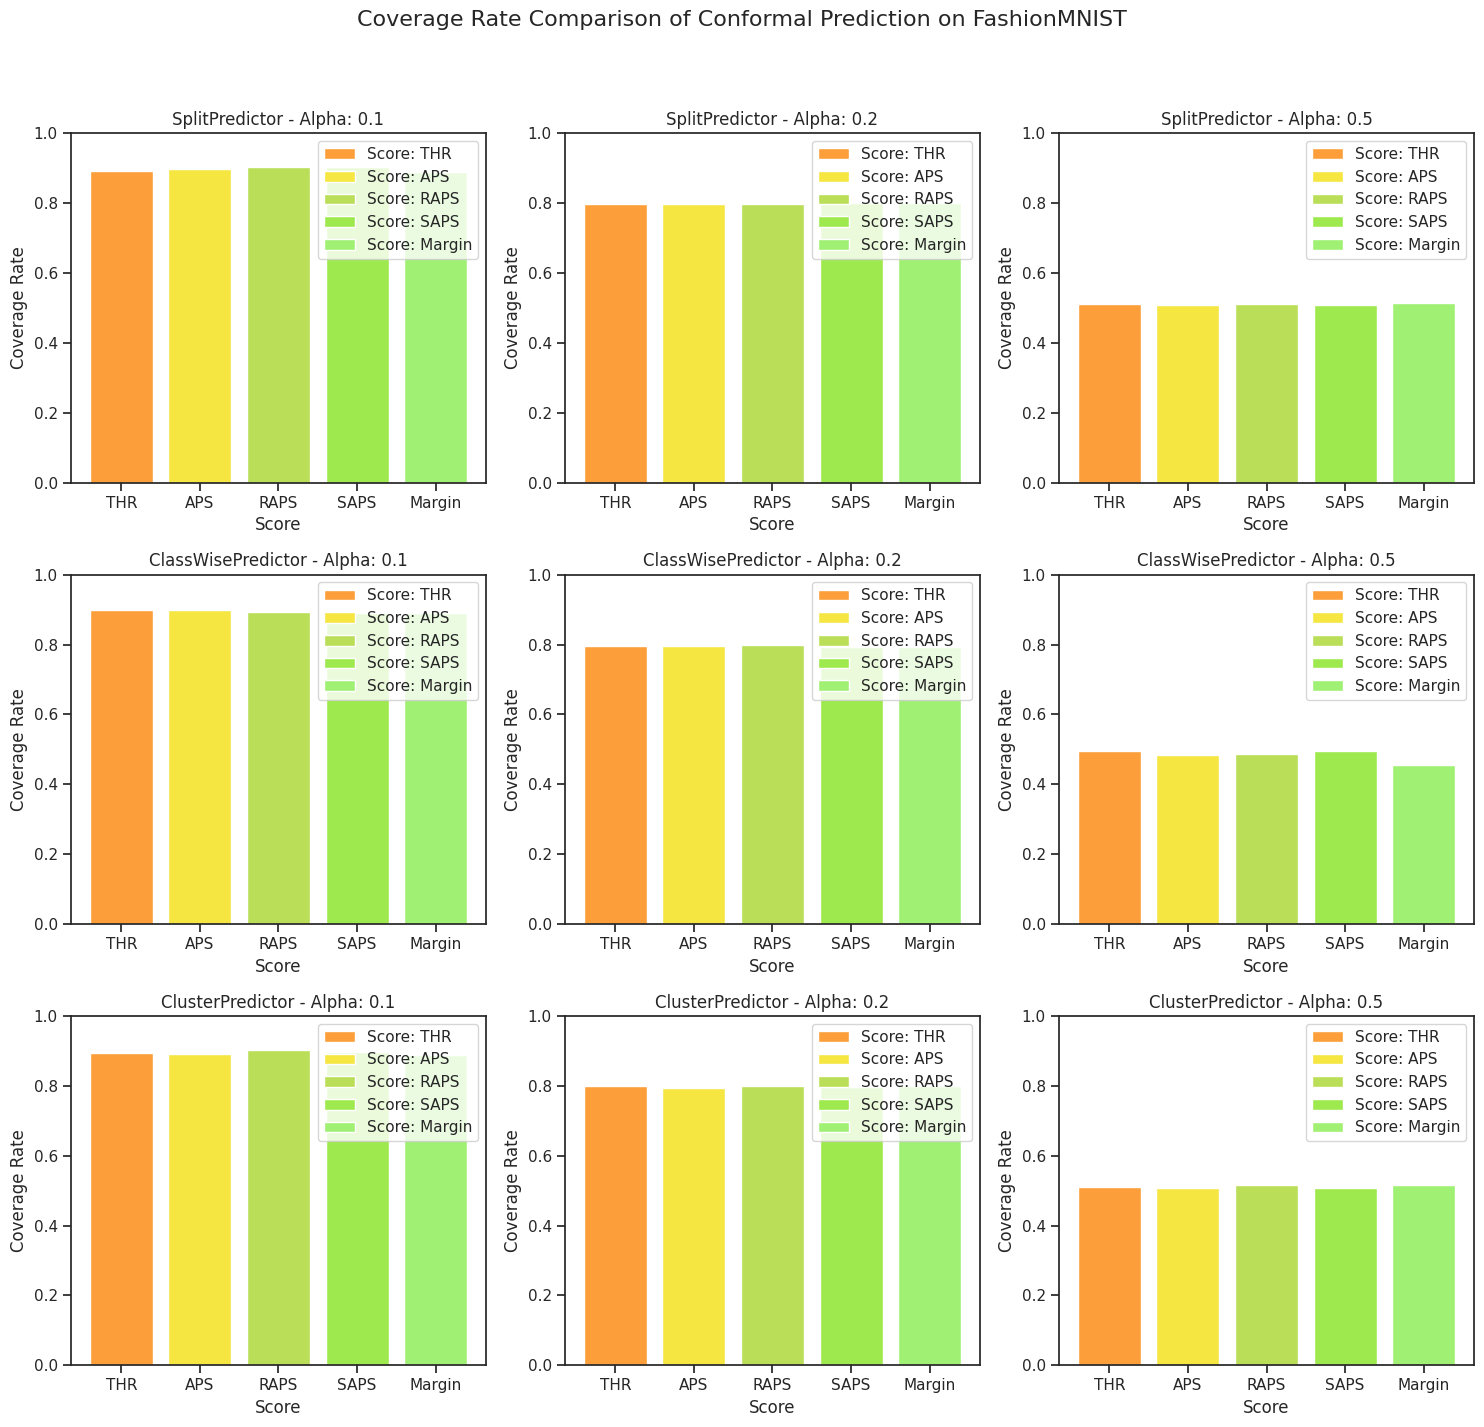

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="ticks", palette="viridis")
# 实验结果数据（这里只是一个示例）
data = {
    'THR': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.90175, 'Average_size': 9.35475},
            0.2: {'Coverage_rate': 0.80975, 'Average_size': 8.34925},
            0.5: {'Coverage_rate': 0.5075, 'Average_size': 5.257},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.89925, 'Average_size': 8.41775},
            0.2: {'Coverage_rate': 0.79375, 'Average_size': 7.482},
            0.5: {'Coverage_rate': 0.4855, 'Average_size': 5.022},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.90175, 'Average_size': 9.3545},
            0.2: {'Coverage_rate': 0.8095, 'Average_size': 8.347},
            0.5: {'Coverage_rate': 0.50675, 'Average_size': 5.2365},
        },
    },
    'APS': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.90175, 'Average_size': 9.20275},
            0.2: {'Coverage_rate': 0.81225, 'Average_size': 8.32775},
            0.5: {'Coverage_rate': 0.5105, 'Average_size': 5.402},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.89775, 'Average_size': 8.25475},
            0.2: {'Coverage_rate': 0.788, 'Average_size': 7.2095},
            0.5: {'Coverage_rate': 0.50675, 'Average_size': 5.09975},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.905, 'Average_size': 9.22375},
            0.2: {'Coverage_rate': 0.80475, 'Average_size': 8.30825},
            0.5: {'Coverage_rate': 0.50625, 'Average_size': 5.357},
        },
    },
    'RAPS': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.90225, 'Average_size': 9.179},
            0.2: {'Coverage_rate': 0.80475, 'Average_size': 8.314},
            0.5: {'Coverage_rate': 0.50475, 'Average_size': 5.37775},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.89725, 'Average_size': 8.25625},
            0.2: {'Coverage_rate': 0.79575, 'Average_size': 7.275},
            0.5: {'Coverage_rate': 0.50325, 'Average_size': 5.10075},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.903, 'Average_size': 9.20275},
            0.2: {'Coverage_rate': 0.80475, 'Average_size': 8.325},
            0.5: {'Coverage_rate': 0.51025, 'Average_size': 5.3765},
        },
    },
    'SAPS': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.898, 'Average_size': 9.197},
            0.2: {'Coverage_rate': 0.80475, 'Average_size': 8.336},
            0.5: {'Coverage_rate': 0.50725, 'Average_size': 5.293},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.89425, 'Average_size': 8.3475},
            0.2: {'Coverage_rate': 0.78575, 'Average_size': 7.224},
            0.5: {'Coverage_rate': 0.4955, 'Average_size': 5.038},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.90175, 'Average_size': 9.183},
            0.2: {'Coverage_rate': 0.80025, 'Average_size': 8.31375},
            0.5: {'Coverage_rate': 0.50825, 'Average_size': 5.29775},
        },
    },
    'Margin': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.902, 'Average_size': 9.45775},
            0.2: {'Coverage_rate': 0.813, 'Average_size': 8.59725},
            0.5: {'Coverage_rate': 0.50825, 'Average_size': 4.86375},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.8915, 'Average_size': 8.38825},
            0.2: {'Coverage_rate': 0.799, 'Average_size': 7.6395},
            0.5: {'Coverage_rate': 0.49775, 'Average_size': 5.4745},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.9005, 'Average_size': 9.44425},
            0.2: {'Coverage_rate': 0.81275, 'Average_size': 8.59375},
            0.5: {'Coverage_rate': 0.511, 'Average_size': 4.89325},
        },
    },
}
# Update the existing data with new_data
for score, predictors in new_data.items():
    for predictor, alpha_data in predictors.items():
        for alpha, result in alpha_data.items():
            data[score][predictor][alpha] = result

# Plotting code remains the same

# Set the plotting style
base_colors = ["#FC9F3A","#F5E641","#BADE58", "#9EE94E","#A0F074",]
sns.set(style="ticks", palette=base_colors)
# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Plot the data
for i, (predictor, alpha_data) in enumerate(data['THR'].items()):  # Assuming 'THR' as an example score
    for j, (alpha, result) in enumerate(alpha_data.items()):
        ax = axes[i, j]
        
        for score, score_data in data.items():
            coverage_rate = score_data[predictor][alpha]['Coverage_rate']
            ax.bar(score, coverage_rate, label=f'Score: {score}')

        ax.set_title(f'{predictor} - Alpha: {alpha}')
        ax.set_xlabel('Score')
        ax.set_ylabel('Coverage Rate')
        ax.set_ylim(0, 1)
        ax.legend()

# Set the overall title
fig.suptitle('Coverage Rate Comparison of Conformal Prediction on FashionMNIST', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


In [69]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10  # Import CIFAR10
from torchvision import transforms
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchcp.classification.scores import THR, APS, RAPS, SAPS, Margin
from torchcp.utils import fix_randomness
from torchcp.classification.utils.metrics import Metrics

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Simple CNN model for demonstration purposes
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=10):  # Adjust the number of classes for CIFAR-10
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = torch.nn.Linear(16 * 16 * 32, num_classes)  # Adjust the input size for CIFAR-10

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 16 * 32)
        x = self.fc(x)
        return x

def test_cifar10():
    fix_randomness(seed=0)
    model_name = 'CNN'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Load or generate CIFAR-10 dataset
    cifar10_test = CIFAR10(root='./shareddata', train=False, download=True, transform=transform)

    dataset_length = len(cifar10_test)

    cal_length = int(0.6 * dataset_length)  
    test_length = dataset_length - cal_length  

    cal_dataset, test_dataset = torch.utils.data.random_split(cifar10_test, [cal_length, test_length])

    model = SimpleCNN(num_classes=10)  
    model.to(device)

    cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64, shuffle=True, pin_memory=True)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
        
    alpha_values = [0.1, 0.2, 0.5] 
    predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
    score_functions = [THR(), APS(), RAPS(1, 0), SAPS(0.2), Margin()]

    for alpha in alpha_values:
        for score in score_functions:
            for class_predictor in predictors:
                predictor = class_predictor(score, model)
                predictor.calibrate(cal_data_loader, alpha)

                # Print experiment details and save results to a file
                experiment_details = f"Experiment--Data : cifar10, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}"
                print(experiment_details)
            
                evaluation_results = predictor.evaluate(test_data_loader)
                print(evaluation_results)

                with open('experiment_results.txt', 'a') as file:
                    file.write(experiment_details + '\n')
                    file.write(str(evaluation_results) + '\n')

In [70]:
test_cifar10()

Files already downloaded and verified
Experiment--Data : cifar10, Model : CNN, Score : THR, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.90675, 'Average_size': 8.90125}
Experiment--Data : cifar10, Model : CNN, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.907, 'Average_size': 8.692}
Experiment--Data : cifar10, Model : CNN, Score : THR, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.90525, 'Average_size': 8.878}
Experiment--Data : cifar10, Model : CNN, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.91025, 'Average_size': 9.01975}
Experiment--Data : cifar10, Model : CNN, Score : APS, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.903, 'Average_size': 8.814}
Experiment--Data : cifar10, Model : CNN, Score : APS, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.907, 'Average_size': 8.976}
Experiment--Data : cifar10, Model : CNN, Score : RAPS, Predictor : SplitPredictor, Alpha

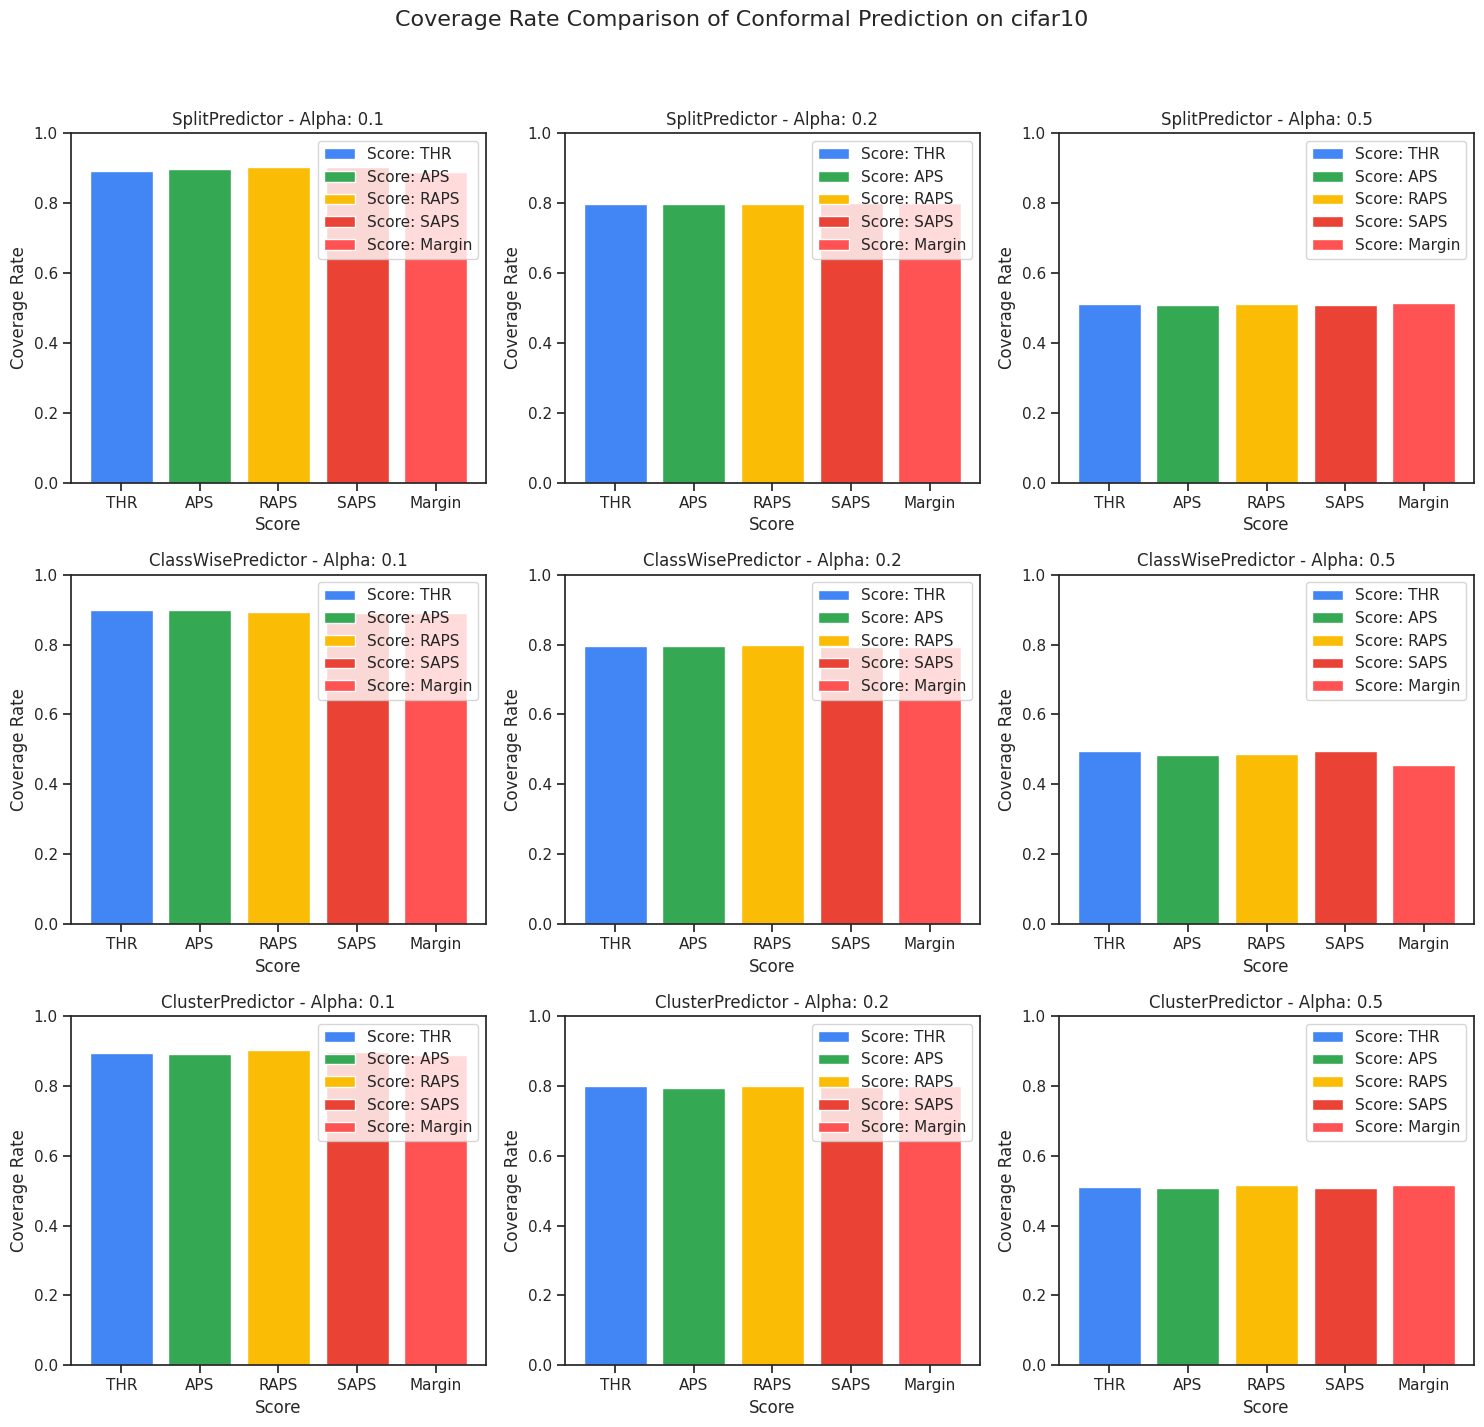

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'THR': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.90675, 'Average_size': 8.90125},
            0.2: {'Coverage_rate': 0.80675, 'Average_size': 7.9125},
            0.5: {'Coverage_rate': 0.50425, 'Average_size': 4.95675},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.907, 'Average_size': 8.692},
            0.2: {'Coverage_rate': 0.8065, 'Average_size': 7.63575},
            0.5: {'Coverage_rate': 0.50325, 'Average_size': 4.8395},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.90525, 'Average_size': 8.878},
            0.2: {'Coverage_rate': 0.80725, 'Average_size': 7.9275},
            0.5: {'Coverage_rate': 0.50275, 'Average_size': 4.91925},
        },
    },
    'APS': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.91025, 'Average_size': 9.01975},
            0.2: {'Coverage_rate': 0.805, 'Average_size': 7.97325},
            0.5: {'Coverage_rate': 0.50975, 'Average_size': 4.95325},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.903, 'Average_size': 8.814},
            0.2: {'Coverage_rate': 0.8065, 'Average_size': 7.79475},
            0.5: {'Coverage_rate': 0.5035, 'Average_size': 4.88075},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.907, 'Average_size': 8.976},
            0.2: {'Coverage_rate': 0.805, 'Average_size': 7.97425},
            0.5: {'Coverage_rate': 0.5075, 'Average_size': 4.935},
        },
    },
    'RAPS': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.907, 'Average_size': 9.0065},
            0.2: {'Coverage_rate': 0.8045, 'Average_size': 7.98125},
            0.5: {'Coverage_rate': 0.50625, 'Average_size': 4.92975},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.8985, 'Average_size': 8.7635},
            0.2: {'Coverage_rate': 0.8065, 'Average_size': 7.76325},
            0.5: {'Coverage_rate': 0.5005, 'Average_size': 4.875},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.909, 'Average_size': 9.029},
            0.2: {'Coverage_rate': 0.80725, 'Average_size': 8.006},
            0.5: {'Coverage_rate': 0.51275, 'Average_size': 4.96275},
        },
    },
    'SAPS': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.906, 'Average_size': 8.99325},
            0.2: {'Coverage_rate': 0.804, 'Average_size': 7.977},
            0.5: {'Coverage_rate': 0.5095, 'Average_size': 4.94175},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.8985, 'Average_size': 8.7625},
            0.2: {'Coverage_rate': 0.8075, 'Average_size': 7.7765},
            0.5: {'Coverage_rate': 0.49775, 'Average_size': 4.914},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.9055, 'Average_size': 9.00175},
            0.2: {'Coverage_rate': 0.802, 'Average_size': 7.94475},
            0.5: {'Coverage_rate': 0.50425, 'Average_size': 4.9135},
        },
    },
    'Margin': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.916, 'Average_size': 9.00475},
            0.2: {'Coverage_rate': 0.80725, 'Average_size': 7.94025},
            0.5: {'Coverage_rate': 0.515, 'Average_size': 5.065},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.9065, 'Average_size': 8.73225},
            0.2: {'Coverage_rate': 0.8035, 'Average_size': 7.728},
            0.5: {'Coverage_rate': 0.5035, 'Average_size': 4.98625},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.91325, 'Average_size': 8.971},
            0.2: {'Coverage_rate': 0.80675, 'Average_size': 7.927},
            0.5: {'Coverage_rate': 0.515, 'Average_size': 5.065},
        },
    },
}

# Update the existing data with new_data
for score, predictors in new_data.items():
    for predictor, alpha_data in predictors.items():
        for alpha, result in alpha_data.items():
            data[score][predictor][alpha] = result

# Plotting code remains the same

# Set the plotting style
custom_palette = ["#4285F4", "#34A853", "#FBBC05", "#EA4335", "#FF5252"]
sns.set(style="ticks", palette=custom_palette)
# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Plot the data
for i, (predictor, alpha_data) in enumerate(data['THR'].items()):  # Assuming 'THR' as an example score
    for j, (alpha, result) in enumerate(alpha_data.items()):
        ax = axes[i, j]
        
        for score, score_data in data.items():
            coverage_rate = score_data[predictor][alpha]['Coverage_rate']
            ax.bar(score, coverage_rate, label=f'Score: {score}')

        ax.set_title(f'{predictor} - Alpha: {alpha}')
        ax.set_xlabel('Score')
        ax.set_ylabel('Coverage Rate')
        ax.set_ylim(0, 1)
        ax.legend()

# Set the overall title
fig.suptitle('Coverage Rate Comparison of Conformal Prediction on cifar10', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


In [72]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchcp.classification.scores import THR, APS, RAPS, SAPS, Margin
from torchcp.utils import fix_randomness
from torchcp.classification.utils.metrics import Metrics

# 数据集的预处理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 简单的 CNN 模型
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = torch.nn.Linear(14 * 14 * 32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 14 * 14 * 32)
        x = self.fc(x)
        return x

def test_mnist():
    fix_randomness(seed=0)
    model_name = 'SimpleCNN'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # 加载 MNIST 数据集
    mnist_test = MNIST(root='./shareddata', train=False, download=True, transform=transform)

    # 确定数据集的长度
    dataset_length = len(mnist_test)

    # 定义所需的拆分长度
    cal_length = int(0.6 * dataset_length)  
    test_length = dataset_length - cal_length  

    # 执行拆分
    cal_dataset, test_dataset = torch.utils.data.random_split(mnist_test, [cal_length, test_length])

    model = SimpleCNN(num_classes=10)
    model.to(device)

    cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64, shuffle=True, pin_memory=True)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
    alpha_values = [0.1, 0.2, 0.5] 
    predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
    score_functions = [THR(), APS(), RAPS(1, 0), SAPS(0.2), Margin()]

    for alpha in alpha_values:
        for score in score_functions:
            for class_predictor in predictors:
                predictor = class_predictor(score, model)
                predictor.calibrate(cal_data_loader, alpha)

                # Print experiment details and save results to a file
                experiment_details = f"Experiment--Data : MNIST, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}"
                print(experiment_details)
            
                evaluation_results = predictor.evaluate(test_data_loader)
                print(evaluation_results)

                with open('experiment_results.txt', 'a') as file:
                    file.write(experiment_details + '\n')
                    file.write(str(evaluation_results) + '\n')

In [73]:
test_mnist()

Experiment--Data : MNIST, Model : SimpleCNN, Score : THR, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.89275, 'Average_size': 8.6775}
Experiment--Data : MNIST, Model : SimpleCNN, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.898, 'Average_size': 8.49825}
Experiment--Data : MNIST, Model : SimpleCNN, Score : THR, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.89375, 'Average_size': 8.69025}
Experiment--Data : MNIST, Model : SimpleCNN, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.897, 'Average_size': 8.7485}
Experiment--Data : MNIST, Model : SimpleCNN, Score : APS, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.9, 'Average_size': 8.8035}
Experiment--Data : MNIST, Model : SimpleCNN, Score : APS, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.8915, 'Average_size': 8.706}
Experiment--Data : MNIST, Model : SimpleCNN, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.1
{'C

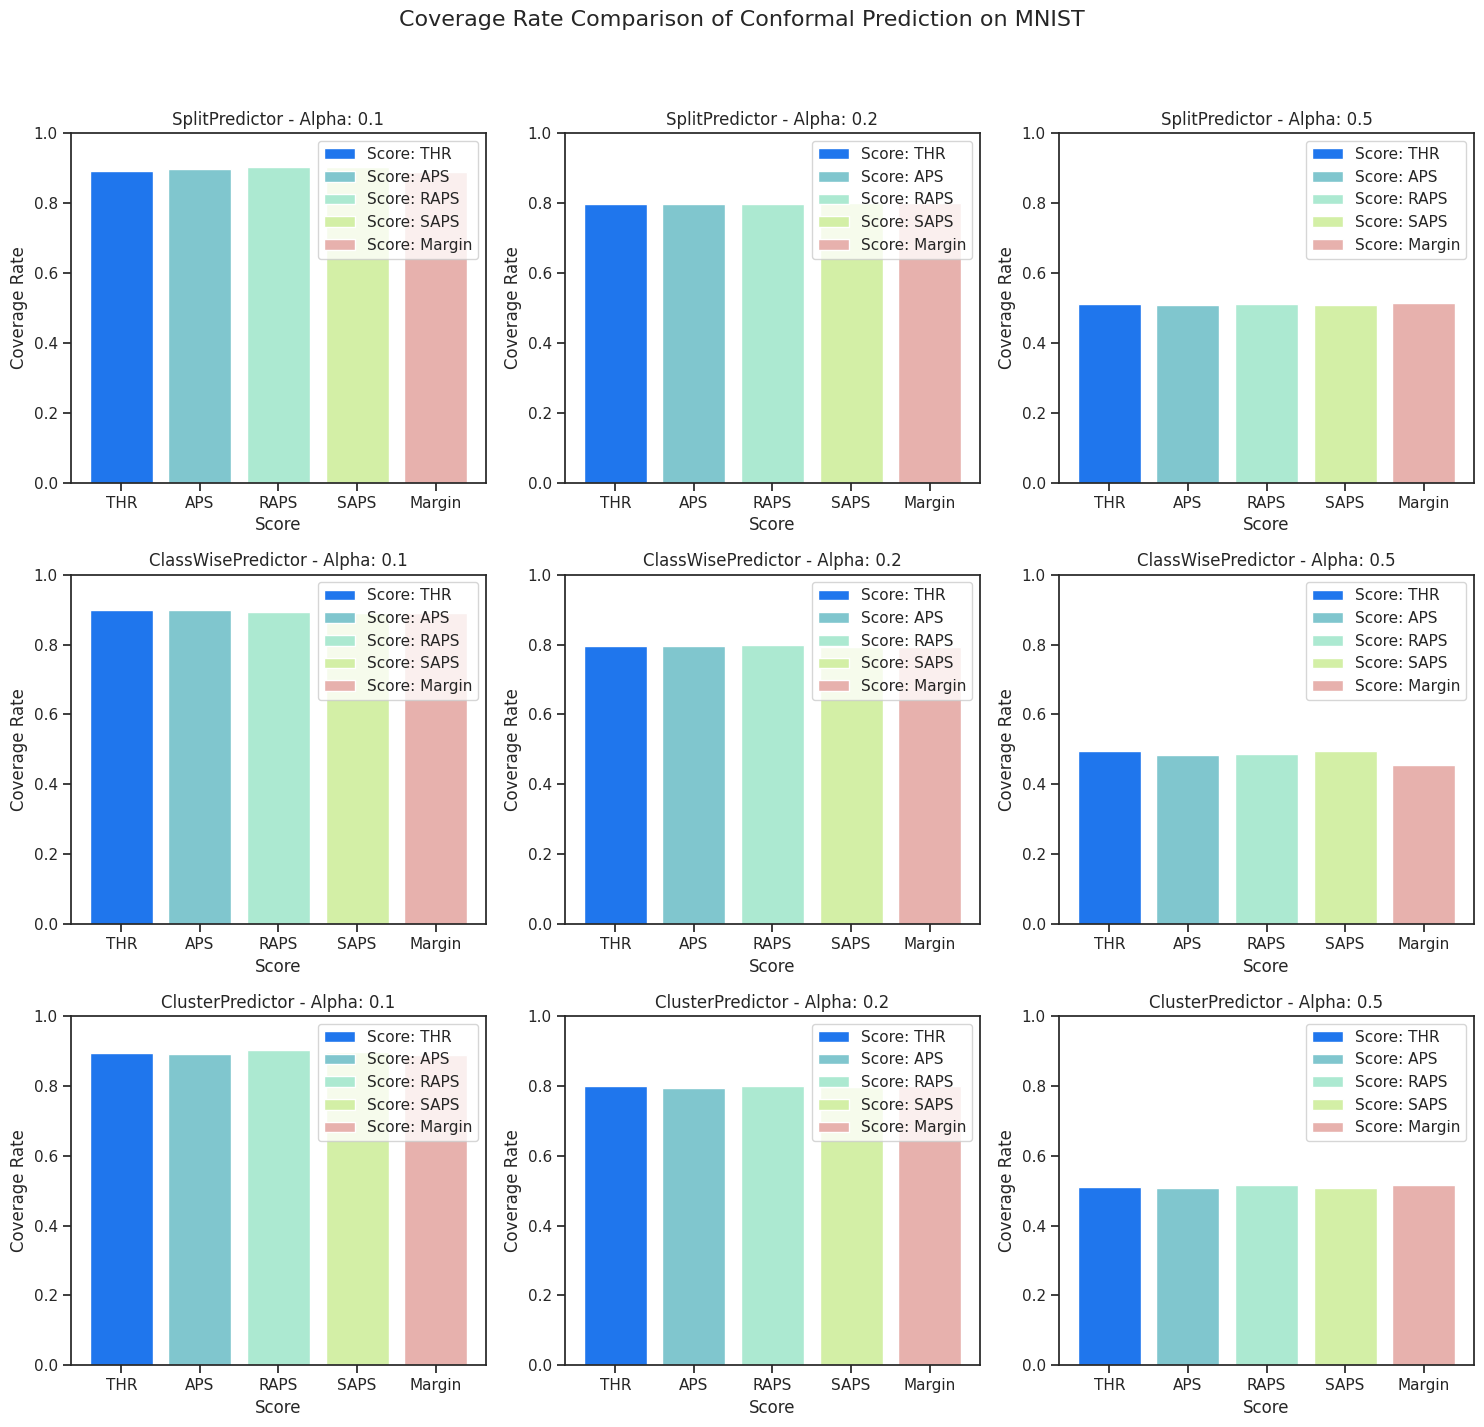

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

new_data = {
    'THR': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.89275, 'Average_size': 8.6775},
            0.2: {'Coverage_rate': 0.79825, 'Average_size': 7.7455},
            0.5: {'Coverage_rate': 0.51, 'Average_size': 5.0265},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.898, 'Average_size': 8.49825},
            0.2: {'Coverage_rate': 0.79625, 'Average_size': 7.58875},
            0.5: {'Coverage_rate': 0.494, 'Average_size': 4.87375},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.89375, 'Average_size': 8.69025},
            0.2: {'Coverage_rate': 0.799, 'Average_size': 7.7515},
            0.5: {'Coverage_rate': 0.51025, 'Average_size': 5.0295},
        },
    },
    'APS': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.897, 'Average_size': 8.7485},
            0.2: {'Coverage_rate': 0.798, 'Average_size': 7.84},
            0.5: {'Coverage_rate': 0.50925, 'Average_size': 5.12925},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.9, 'Average_size': 8.8035},
            0.2: {'Coverage_rate': 0.7965, 'Average_size': 7.7845},
            0.5: {'Coverage_rate': 0.483, 'Average_size': 4.968},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.8915, 'Average_size': 8.706},
            0.2: {'Coverage_rate': 0.7935, 'Average_size': 7.794},
            0.5: {'Coverage_rate': 0.50775, 'Average_size': 5.11875},
        },
    },
    'RAPS': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.9025, 'Average_size': 8.7535},
            0.2: {'Coverage_rate': 0.7975, 'Average_size': 7.8355},
            0.5: {'Coverage_rate': 0.51175, 'Average_size': 5.1315},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.89425, 'Average_size': 8.7445},
            0.2: {'Coverage_rate': 0.798, 'Average_size': 7.79875},
            0.5: {'Coverage_rate': 0.4855, 'Average_size': 4.981},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.9025, 'Average_size': 8.803},
            0.2: {'Coverage_rate': 0.8, 'Average_size': 7.8335},
            0.5: {'Coverage_rate': 0.51475, 'Average_size': 5.16675},
        },
    },
    'SAPS': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.9025, 'Average_size': 8.79425},
            0.2: {'Coverage_rate': 0.79925, 'Average_size': 7.85325},
            0.5: {'Coverage_rate': 0.508, 'Average_size': 5.0895},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.8915, 'Average_size': 8.80475},
            0.2: {'Coverage_rate': 0.793, 'Average_size': 7.75575},
            0.5: {'Coverage_rate': 0.49525, 'Average_size': 5.02125},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.898, 'Average_size': 8.75575},
            0.2: {'Coverage_rate': 0.79775, 'Average_size': 7.882},
            0.5: {'Coverage_rate': 0.50825, 'Average_size': 5.085},
        },
    },
    'Margin': {
        'SplitPredictor': {
            0.1: {'Coverage_rate': 0.88825, 'Average_size': 8.85425},
            0.2: {'Coverage_rate': 0.8005, 'Average_size': 7.851},
            0.5: {'Coverage_rate': 0.5145, 'Average_size': 5.01475},
        },
        'ClassWisePredictor': {
            0.1: {'Coverage_rate': 0.89125, 'Average_size': 8.686},
            0.2: {'Coverage_rate': 0.794, 'Average_size': 7.7915},
            0.5: {'Coverage_rate': 0.45525, 'Average_size': 4.711},
        },
        'ClusterPredictor': {
            0.1: {'Coverage_rate': 0.88975, 'Average_size': 8.86925},
            0.2: {'Coverage_rate': 0.79925, 'Average_size': 7.8375},
            0.5: {'Coverage_rate': 0.51475, 'Average_size': 5.0165},
        },
    },
}


for score, predictors in new_data.items():
    for predictor, alpha_data in predictors.items():
        for alpha, result in alpha_data.items():
            data[score][predictor][alpha] = result

base_colors = ["#1F76ED","#80C6CE","#ACE9D1", "#D3EFA6","#E7B1AD",]
sns.set(style="ticks", palette=base_colors)
# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Plot the data
for i, (predictor, alpha_data) in enumerate(data['THR'].items()):  # Assuming 'THR' as an example score
    for j, (alpha, result) in enumerate(alpha_data.items()):
        ax = axes[i, j]
        
        for score, score_data in data.items():
            coverage_rate = score_data[predictor][alpha]['Coverage_rate']
            ax.bar(score, coverage_rate, label=f'Score: {score}')

        ax.set_title(f'{predictor} - Alpha: {alpha}')
        ax.set_xlabel('Score')
        ax.set_ylabel('Coverage Rate')
        ax.set_ylim(0, 1)
        ax.legend()

# Set the overall title
fig.suptitle('Coverage Rate Comparison of Conformal Prediction on MNIST', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()
